In [1]:
import numpy as np
from Scripts.Configs.ConfigClass import Config
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
from lightning.pytorch.loggers import CSVLogger
import os
from Scripts.DataManager.GraphLoader.AmazonReviewGraphDataModule import AmazonReviewGraphDataModule
import time
import torch
import torch_geometric

config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = 'cuda'
batch_size = 16

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# tag_dep_seq_sent = TextGraphType.DEPENDENCY | TextGraphType.TAGS | TextGraphType.SEQUENTIAL | TextGraphType.SENTENCE

tag_dep_seq_sent = TextGraphType.SENTIMENT
data_manager = AmazonReviewGraphDataModule(config, True, True, shuffle=False, start_data_load=0 , end_data_load = 1000, device='cpu', batch_size=batch_size, graph_type=tag_dep_seq_sent, load_preprocessed_data = False)
data_manager.load_labels()
data_manager.load_graphs()

self.end_data_load: 1000


 Creating Graphs :   0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\fardin\Projects\ColorIntelligence\Scripts\DataManager\GraphConstructor\TagDepTokenGraphConstructor.py:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  data['sentence'].x = torch.tensor(sentence_embeddings, dtype=torch.float32)
 Creating Graphs : 100%|██████████| 1000/1000 [02:11<00:00,  7.59it/s]


In [3]:
# data_manager.update_batch_size(128)
t_dataloader = data_manager.train_dataloader()
v_dataloader = data_manager.val_dataloader()
X1, y1 = next(iter(t_dataloader))
X2, y2 = next(iter(v_dataloader))
# X1.metadata()
len(X1)

16

In [4]:
X1.x_dict['sentence'].shape

torch.Size([101, 300])

In [5]:
# from Scripts.Models.GraphEmbedding.HeteroMempool2 import HeteroMempool2

# mempool_model = HeteroMempool2(X1.metadata(), 1, 128, {'word': 128}, num_clusters=1, node_embedding_layer=4)
# mempool_model.to(device)

# print(next(iter(mempool_model.parameters())).device)
# print(torch_geometric.nn.summary(mempool_model, X1.to(device)))

In [6]:
from Scripts.Models.BaseModels.HeteroGat import HeteroGat
from Scripts.Models.BaseModels.HeteroLinear import HeteroLinear
from Scripts.Models.GraphNodeEmbedding.HeteroDeepGraphNodeEmbedding1 import HeteroDeepGraphNodeEmbedding1
from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding1 import HeteroDeepGraphEmbedding1
from Scripts.Models.GraphEmbedding.HeteroMempool1 import HeteroMempool1

In [7]:
# from torch_geometric.nn import to_hetero
# hetero_model = to_hetero(HeteroGCNConv(300, 1024, 0.2), X2.metadata())
# pre = hetero_model(X2.x_dict, X2.edge_index_dict, X2.edge_attr_dict)

In [8]:
# import torch_geometric
# graph_node_embedding = HeteroDeepGraphNodeEmbedding1(300, 128, X1.metadata(), 128, dropout=0.2)
# graph_node_embedding.to(device)
# graph_embedding = HeteroMempool1(graph_node_embedding, 1, 128, num_clusters=3, pooling_node_types={'word': 128, 'tag': 128, 'dep': 128})
# graph_embedding = graph_embedding.to(device)
# print(next(iter(graph_embedding.parameters())).device)
# print(torch_geometric.nn.summary(graph_embedding, X1.to(device)))

In [9]:
# graph_embedding = HeteroDeepGraphEmbedding1(300, 128, X1.metadata(), 128, dropout=0.2, edge_type_count=11)
# graph_embedding = graph_embedding.to(device)
# print(next(iter(graph_embedding.parameters())).device)
# print(torch_geometric.nn.summary(graph_embedding, X1.to(device)))

In [10]:
from Scripts.Models.LightningModels.LightningModels import HeteroBinaryLightningModel
from Scripts.Models.LossFunctions.HeteroLossFunctions import HeteroLossArgs, HeteroLoss1, HeteroLoss2
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import lightning as L
from lightning.pytorch.tuner import Tuner
from Scripts.Models.ModelsManager.ClassifierModelManager import ClassifierModelManager

In [11]:
# x_dict_keys = X1.x_dict.keys()
# x_dict_keys-'word'

In [12]:
# step_size = 5000
# for i in range(0, 110000, step_size):
#     print(f'{i}, {i+step_size}')
#     data_manager.create_sub_data_loader(i, i+step_size)
#     # t_dataloader = data_manager2.train_dataloader()
#     # v_dataloader = data_manager2.val_dataloader()
#     # X1, y1 = next(iter(t_dataloader))
#     # X2, y2 = next(iter(v_dataloader))
    
#     callbacks = [
#         ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True),
#         # EarlyStopping(patience=50, mode='max', monitor='val_acc')
#     ]
#     torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 64, dropout=0.3)
#     torch_model = torch_model.to(device)
#     lightning_model = HeteroBinaryLightningModel(torch_model,
#                                                  torch.optim.Adam(torch_model.parameters(), lr=0.0046, weight_decay=0.001),
#                                         loss_func=HeteroLoss1(exception_keys=['word'], enc_factor=0.005),
#                                         learning_rate=0.0046,
#                                         batch_size=batch_size,
#                                         user_lr_scheduler=False,
#                                         min_lr=0.0001
#                                         ).to(device)
#     model_manager = ClassifierModelManager(torch_model, lightning_model, model_save_dir=r'C:\Users\fardin\Projects\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs', log_name='test_data_2', device=device, num_train_epoch=10)
#     model_manager.fit(datamodule=data_manager)
#     model_manager.save_plot_csv_logger(name_prepend=f'{i}, {i+step_size}', loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])
#     # X1.metadata()
    

In [13]:
# from typing import List
# import torch
# from torch import nn


# class HeteroLossArgs:
#     def __init__(self, y, x_dict):
#         self.y = y
#         self.x_dict = x_dict
        
# class HeteroLoss1(torch.nn.Module):
#     def __init__(self, exception_keys: List[str], enc_factor=0.0, *args, **kwargs) -> None:
#         super().__init__(*args, **kwargs)
#         self.bce_loss=  nn.BCEWithLogitsLoss()
#         self.mse_loss = nn.MSELoss()
#         self.exception_keys = exception_keys
#         self.enc_factor = enc_factor
    
#     def forward(self, out_pred, out_main):
#         loss = self.bce_loss(out_pred.y, out_main.y)
#         x_dict_keys = [k for k in out_pred.x_dict.keys() if k not in self.exception_keys]
        
#         for key in x_dict_keys:
#             tensor1 = out_pred.x_dict[key]
#             tensor2 = out_main.x_dict[key]
#             if tensor2.ndim == 1 and tensor2.dtype is torch.long:
#                 tensor2 = torch.nn.functional.one_hot(input=tensor2.to(torch.long), num_classes=tensor1.shape[1]).to(torch.float32)
#             loss += self.enc_factor * self.mse_loss(tensor1, tensor2)
#         return loss
    

In [14]:
# X1.metadata()

In [15]:
# graph_node_embedding = HeteroDeepGraphNodeEmbedding1(300, 128, X1.metadata(), 128, dropout=0.2)
# graph_node_embedding.to(device)
# graph_embedding = HeteroMempool1(graph_node_embedding, 1, 128, num_clusters=3, pooling_node_types={'word':128, 'sentence': 128})
# graph_embedding = graph_embedding.to(device)

In [16]:
graph_embedding = HeteroDeepGraphEmbedding1(300, 1, X1.metadata(), 128, dropout=0.2, edge_type_count=11)
graph_embedding = graph_embedding.to(device)

In [17]:
# mempool_model = HeteroMempool2(X1.metadata(), 1, 128, {'word': 128}, num_clusters=1, node_embedding_layer=4)
# mempool_model.to(device)

In [18]:
# lightning_model = HeteroBinaryLightningModel.load_from_checkpoint(r'C:\Users\fardin\Projects\ColorIntelligence\logs\hetero_model_5\version_0\checkpoints\epoch=7-step=2056.ckpt', model=)

callbacks = [
    ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True),
    # EarlyStopping(patience=50, mode='max', monitor='val_acc')
]
lightning_model = HeteroBinaryLightningModel(graph_embedding,
                                 torch.optim.Adam(graph_embedding.parameters(), lr=0.004, weight_decay=0.001),
                                       loss_func=HeteroLoss1(exception_keys=['word'], enc_factor=0.05),
                                       learning_rate=0.004,
                                       batch_size=batch_size,
                                       user_lr_scheduler=True,
                                       min_lr=0.00005
                                       ).to(device)
model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_6', model_save_dir=r'C:\Users\fardin\Projects\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs\hetero_model_3',device=device, num_train_epoch=500)

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
lightning_model = HeteroBinaryLightningModel(graph_embedding,
                                 torch.optim.Adam(graph_embedding.parameters(), lr=0.0001, weight_decay=0.001),
                                       loss_func=HeteroLoss1(exception_keys=['word'], enc_factor=0.01),
                                       learning_rate=0.0005,
                                       batch_size=batch_size,
                                       user_lr_scheduler=True,
                                       min_lr=0.00001
                                       ).to(device)
model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_3', model_save_dir=r'C:\Users\fardin\Projects\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs\hetero_model_3',device=device, num_train_epoch=500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
# model_manager.tune(data_manager=data_manager, min_lr=1e-7, max_lr = 1e-2)

In [21]:
model_manager.fit(datamodule=data_manager)

You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding1 | 2.2 M 
1 | loss_func | HeteroLoss1               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.829     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-package

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:58: Detected KeyboardInterrupt, attempting graceful shutdown...


In [115]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

def evaluate(eval_dataloader,
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False):
        y_true = []
        y_pred = []
        model_manager.lightning_model.eval()
        for X, y in eval_dataloader:
            # print(f"ii: {X3.edge_index_dict[('word', 'word_sentiment', 'sentiment')]}")
            y_p, _ = model_manager.torch_model(X.to(device))
            y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
            y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        print(f"ii: {y_true.shape} : {y_pred.shape}")
        if(give_confusion_matrix):
            print(f'confusion_matrix: \n{confusion_matrix(y_true, y_pred)}')
        if(give_report):
            print(classification_report(y_true, y_pred))
        if(give_f1_score):
            print(f'f1_score: {f1_score(y_true, y_pred)}')
        if(give_accuracy_score):
            print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')
        if(give_precision_score):
            print(f'precision_score: {precision_score(y_true, y_pred)}')
        if(give_recall_score):
            print(f'recall_score: {recall_score(y_true, y_pred)}')
        if(give_hinge_loss):
            print(f'hinge_loss: {hinge_loss(y_true, y_pred)}')

In [116]:
X3, y3 = next(iter(data_manager.test_dataloader()))

In [117]:
X3.edge_index_dict[('sentence', 'sentence_word', 'word')].dtype

torch.int64

In [118]:
X3.edge_index_dict[('word', 'word_sentiment', 'sentiment')].dtype

torch.int64

In [119]:
X3.metadata()

(['dep', 'tag', 'word', 'sentence', 'general', 'sentiment'],
 [('dep', 'dep_word', 'word'),
  ('word', 'word_dep', 'dep'),
  ('tag', 'tag_word', 'word'),
  ('word', 'word_tag', 'tag'),
  ('word', 'seq', 'word'),
  ('general', 'general_sentence', 'sentence'),
  ('sentence', 'sentence_general', 'general'),
  ('word', 'word_sentence', 'sentence'),
  ('sentence', 'sentence_word', 'word'),
  ('word', 'word_sentiment', 'sentiment'),
  ('sentiment', 'sentiment_word', 'word')])

In [122]:
evaluate(data_manager.val_dataloader())

ii: torch.Size([200, 1]) : torch.Size([200, 1])
confusion_matrix: 
[[65 42]
 [18 75]]
              precision    recall  f1-score   support

           0       0.78      0.61      0.68       107
           1       0.64      0.81      0.71        93

    accuracy                           0.70       200
   macro avg       0.71      0.71      0.70       200
weighted avg       0.72      0.70      0.70       200



In [ ]:
# model_manager.lightning_model.loss_func = HeteroLoss1(exception_keys=['word'], enc_factor=0.05)

In [40]:
lightning_model.lr_scheduler.min_lrs = [1e-05]

In [41]:
print(lightning_model.lr_scheduler.min_lrs)

[1e-05]


In [46]:
model_manager.trainer.save_checkpoint(r'C:\Users\fardin\Desktop\Learning Parts 2\part1\deep_graph_embedding_1.ckpt')

In [49]:
custom_model = HeteroBinaryLightningModel.load_from_checkpoint(r'C:\Users\fardin\Desktop\Learning Parts 2\part1\deep_graph_embedding_1.ckpt', model=graph_embedding)

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [50]:
test_dataloader = data_manager.test_dataloader()
x_t, y_t = next(iter(test_dataloader))
len(x_t)

256

In [53]:
custom_model.eval()
y_pred = custom_model(x_t.to(device))

In [55]:
y_t

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
      

In [88]:
y_pred2 = (y_pred[0]>0).to(torch.int)
y_pred2 = y_pred2.to('cpu')

In [89]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, accuracy_score, classification_report

In [91]:
print(classification_report(y_t, y_pred2))

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93       132
         1.0       0.93      0.92      0.92       124

    accuracy                           0.93       256
   macro avg       0.93      0.93      0.93       256
weighted avg       0.93      0.93      0.93       256



In [92]:
confusion_matrix(y_t, y_pred2)

array([[123,   9],
       [ 10, 114]], dtype=int64)

In [98]:
import spacy
from IPython.display import clear_output
nlp = spacy.load('en_core_web_lg')
def convert_to_sentence(vectors):
    words = []
    print(len(vectors))
    for i in range(len(vectors)):
        clear_output()
        print(f'{i}/{len(vectors)}')
        ms = nlp.vocab.vectors.most_similar(np.asarray([vectors[i]]), n=1)
        ws = [nlp.vocab.strings[w] for w in ms[0][0]]
        # print(ws)
        for w in ws:
            words.append(w)
        # if (i+1)%5==0:
        #     break
    return str.join(' ', words)

In [100]:
false_prediction_index = 0
x_t_cpu = x_t.to('cpu')
for i in range(100, len(y_t)):
    if y_t[i][0] != y_pred2[i][0]:
        false_prediction_index = i
        break
sent1 = convert_to_sentence(x_t_cpu[false_prediction_index].x_dict['word'])
print(f'{i}. true:{y_t[i]}, prediction: {y_pred2[i]}, \n sentence: {sent1}')

110/111
112. true:tensor([1.]), prediction: tensor([0], dtype=torch.int32), 
 sentence: the book contain several interesting example of utterance which tend to be speak with the same intonation in american English . for instance , child tease each other by singe something like " Johnny have a girlfriend " on so - so - mi - la - so - mi . although none of the writer on stylized speak intonation attempt to identify the musical pitch which they refer to , a reader with musical training might be able to identify those pitch . [ ... ] and see if you agree that the four pitch of american stylized speak intonation be do , mi , so , and la .


In [64]:
torch.max(y_pred[0])

tensor(9.1909, device='cuda:0', grad_fn=<MaxBackward1>)

In [42]:
lightning_model.loss_func=HeteroLoss1(exception_keys=['word'], enc_factor=0.00015)

In [43]:
model_manager.update_learning_rate(0.0003)

In [44]:
model_manager.fit(datamodule=data_manager)

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_6\version_1\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding1 | 2.2 M 
1 | loss_func | HeteroLoss1               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.829     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which ma

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:58: Detected KeyboardInterrupt, attempting graceful shutdown...


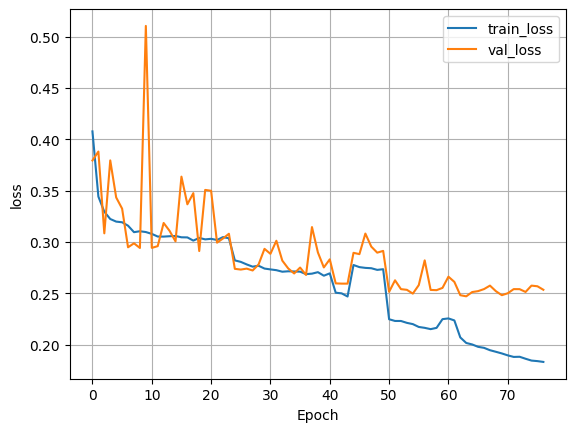

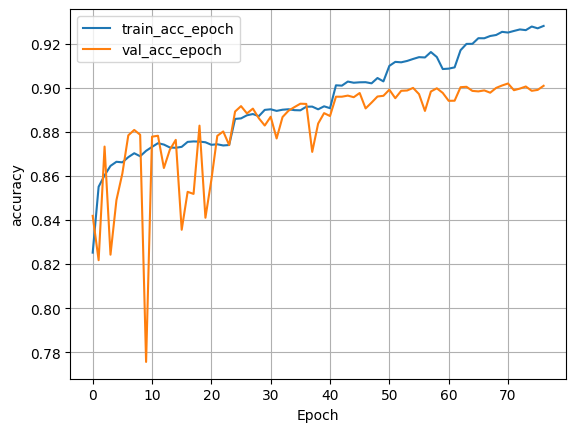

In [45]:
model_manager.plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [ ]:
# enc_factor = 0.3
# model_manager.plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [ ]:
# enc_factor = 0
# model_manager.plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [ ]:
# enc_factor = 0.1
# model_manager.plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [ ]:
# from typing import List
# def find_best_settings(lrs: List[float]=[0.001], dropouts: List[float]=[0.2], weight_decays: List[float]=[0.00055], emb_factors: List[float]=[0.1], batch_sizes: List[int]=[128], log_name='find_best_settings'):
#     for lr in lrs:
#         for dropout in dropouts:
#             for wd in weight_decays:
#                 for emb_factor in emb_factors:
#                     for bs in batch_sizes:
#                         data_manager.update_batch_size(bs)
#                         torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 128, dropout=dropout)
#                         lightning_model = HeteroBinaryLightningModel(torch_model,
#                                         torch.optim.Adam(torch_model.parameters(), lr=lr, weight_decay=wd),
#                                             loss_func=HeteroLoss1(exception_keys='word', enc_factor=emb_factor),
#                                             learning_rate=lr,
#                                             batch_size=bs,
#                                             user_lr_scheduler=True
#                                             ).to(device)
#                         model_manager = ClassifierModelManager(torch_model, lightning_model, log_name=log_name, device=device, num_train_epoch=10)
#                         model_manager.fit(datamodule=data_manager)
#                         model_manager.save_plot_csv_logger(name_prepend=f'{lr}_{dropout}_{wd}_{emb_factor}_{bs}', loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 1.8 M 
1 | loss_func | HeteroLoss1        | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.352     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 1.8 M 
1 | loss_func | HeteroLoss1        | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.352     Total e

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 1.8 M 
1 | loss_func | HeteroLoss1        | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.352     Total e

bbbb


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 1.8 M 
1 | loss_func | HeteroLoss1        | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.352     Total e

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 1.8 M 
1 | loss_func | HeteroLoss1        | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.352     Total e

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 1.8 M 
1 | loss_func | HeteroLoss1        | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.352     Total e

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 1.8 M 
1 | loss_func | HeteroLoss1        | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.352     Total e

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 1.8 M 
1 | loss_func | HeteroLoss1        | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.352     Total e

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


bbbb



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 1.8 M 
1 | loss_func | HeteroLoss1        | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.352     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (11) is smaller than the

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 1.8 M 
1 | loss_func | HeteroLoss1        | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.352     Total e

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


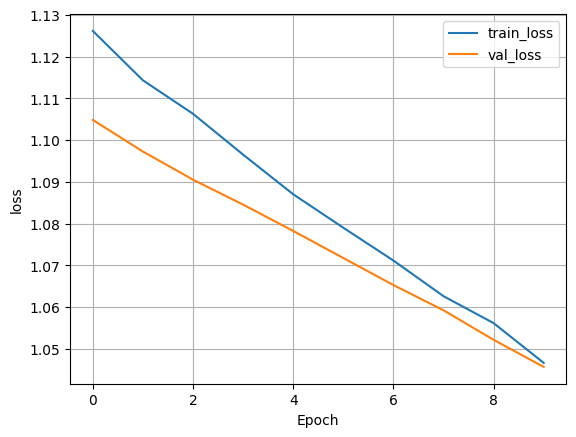

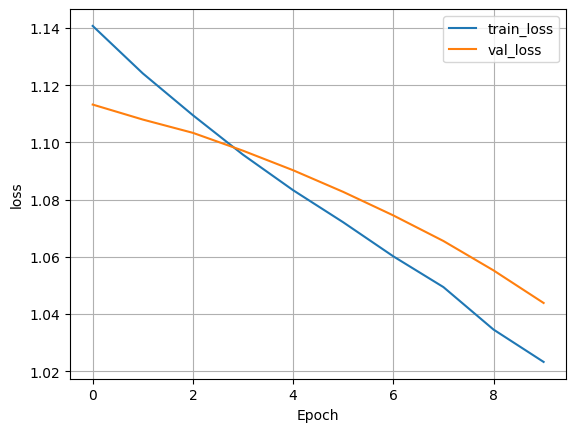

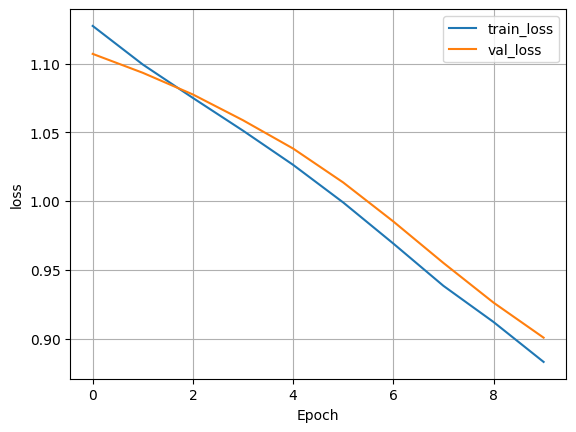

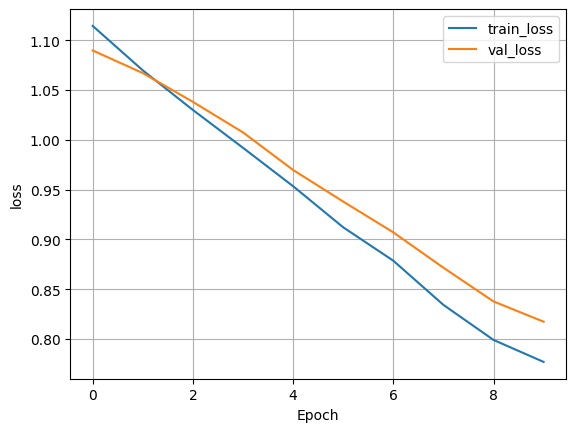

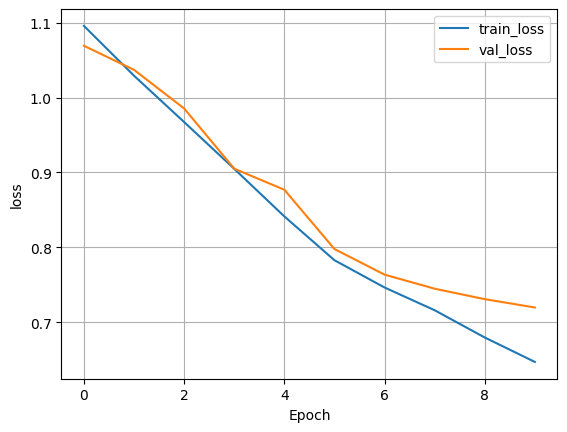

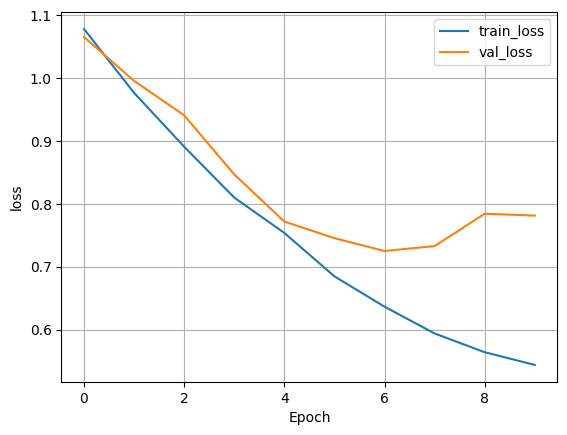

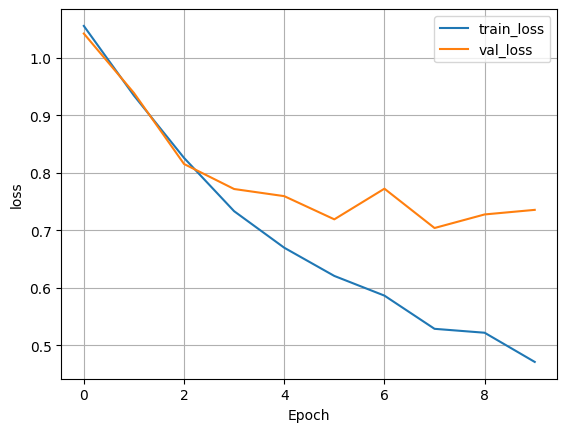

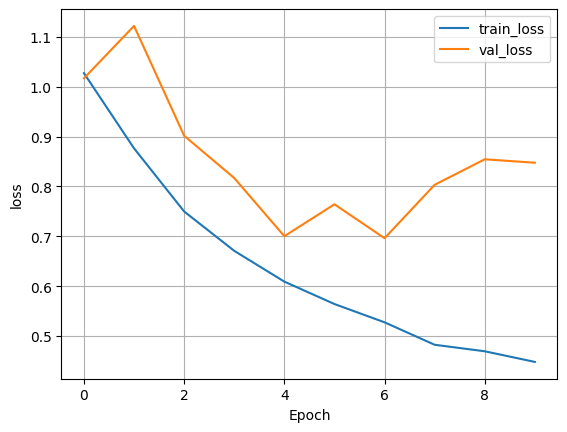

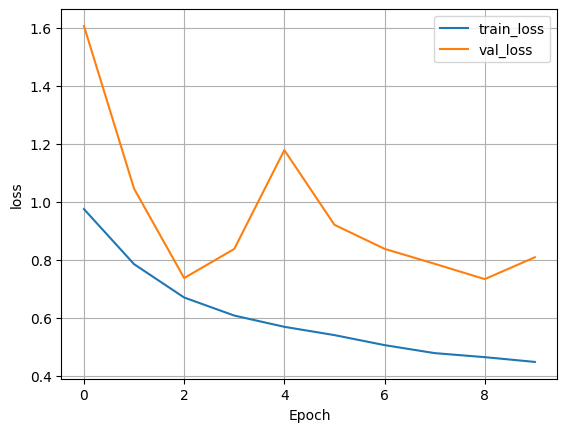

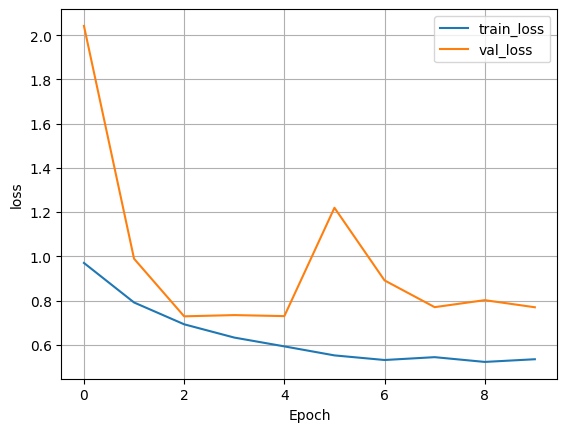

In [ ]:
# lrs = np.logspace(-4.5,-2.3,10)
# dropouts = [0.2] #np.linspace(0.2, 0.6, 5)
# weight_decays = [0.001]# np.logspace(-5,-2,10)
# emb_factors = [0.1]#np.linspace(0.07, 0.3, 3)
# batch_sizes=[256]
# find_best_settings(lrs, dropouts, weight_decays, emb_factors, batch_sizes, log_name='find_lr')

bbbb


You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00478630092322638
Restoring states from the checkpoint path at C:\Users\fardin\Projects\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs\.lr_find_358a4aac-a6e3-4ce6-ab8a-67f8bc0fb17b.ckpt
Restored all states from the checkpoint at C:\Users\fardin\Projects\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs\.lr_find_358a4aac-a6e3-4ce6-ab8a-67f8bc0fb17b.ckpt
c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\ModelsManager\ModelManager.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.00478630092322638

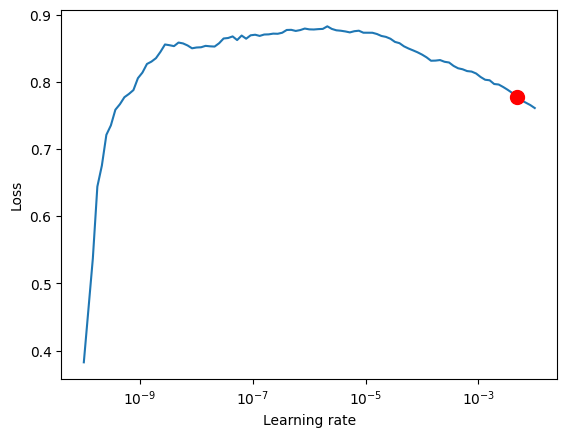

In [ ]:
model_manager.tune(data_manager=data_manager, min_lr=1e-10, max_lr=1e-2)

In [ ]:
# next(iter(model_manager.lightning_model.optimizer.param_groups))['lr']

In [ ]:
model_manager.fit(datamodule=data_manager)

bbbb


You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 21.7 M
1 | loss_func | BCEWithLogitsLoss  | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
21.7 M    Trainable params
0         Non-trainable params
21.7 M    Total params
86.715    Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:58: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
next(iter(model_manager.lightning_model.optimizer.param_groups))['lr']

0.001

In [ ]:
model_manager.lightning_model.update_learning_rate(0.003)

In [ ]:
model_manager.fit(datamodule=data_manager)

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_2\version_27\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 21.7 M
1 | loss_func | BCEWithLogitsLoss  | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
21.7 M    Trainable params
0         Non-trainable params
21.7 M    Total params
86.715    Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:58: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
model_manager.trainer.checkpoint_callback.best_model_path

'logs/hetero_model_2\\version_27\\checkpoints\\epoch=23-step=6298.ckpt'

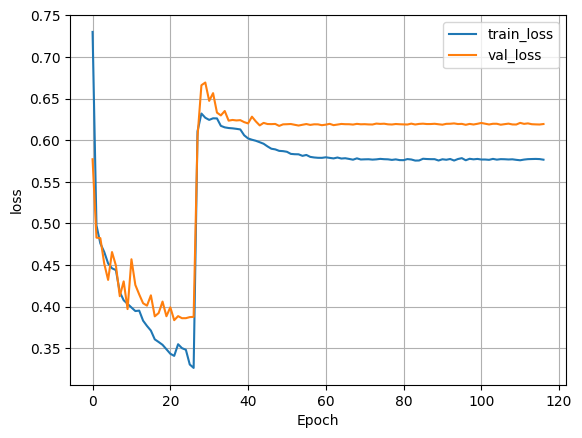

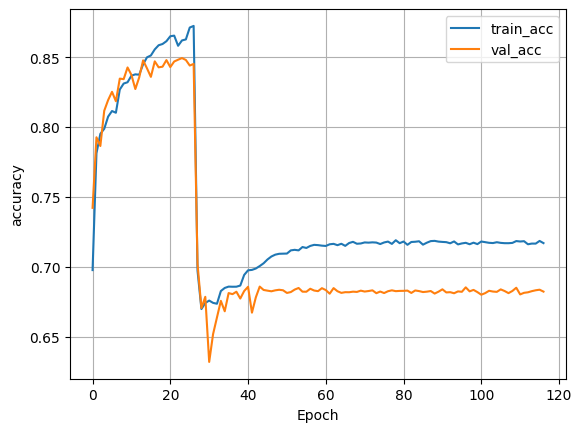

In [ ]:
model_manager.plot_csv_logger()

In [ ]:
model_manager.lightning_model.optimizer.param_groups

[{'lr': 0.0015848931924611143,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0.001,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'differentiable': False,
  'fused': None,
  'params': [Parameter containing:
   tensor([-4.1935e-02,  9.8380e-02, -3.4482e-24,  9.8186e-03,  1.6586e-01,
            5.0821e-02, -3.7323e-02, -7.2108e-02, -9.5253e-22], device='cuda:0',
          requires_grad=True),
   Parameter containing:
   tensor([-2.1126e-28, -4.1121e-15, -6.4317e-01,  6.8596e-06,  1.3726e-01,
           -5.2705e-07, -5.5036e-29,  2.1877e-30,  2.9716e-17], device='cuda:0',
          requires_grad=True),
   Parameter containing:
   tensor([-1.0531,  1.0929,  0.4810,  0.9144, -0.8698, -0.1524,  0.9228, -0.6973,
            0.2059], device='cuda:0', requires_grad=True),
   Parameter containing:
   tensor([ 0.3135, -0.8343, -0.0693,  0.1909, -0.2347, -1.2841, -1.4184, -0.4702,
            0.7692], device='cuda:0', requires_grad=True),
   Par

In [ ]:
for p in model_manager.lightning_model.model.parameters():
    print(p)

Parameter containing:
tensor([-4.1935e-02,  9.8380e-02, -3.4482e-24,  9.8186e-03,  1.6586e-01,
         5.0821e-02, -3.7323e-02, -7.2108e-02, -9.5253e-22], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-2.1126e-28, -4.1121e-15, -6.4317e-01,  6.8596e-06,  1.3726e-01,
        -5.2705e-07, -5.5036e-29,  2.1877e-30,  2.9716e-17], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-1.0531,  1.0929,  0.4810,  0.9144, -0.8698, -0.1524,  0.9228, -0.6973,
         0.2059], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.3135, -0.8343, -0.0693,  0.1909, -0.2347, -1.2841, -1.4184, -0.4702,
         0.7692], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[[ 1.0861e-28, -3.1872e-27,  1.087

KeyboardInterrupt: 

In [ ]:
next(iter(model_manager.lightning_model.optimizer.param_groups))

{'lr': None,
 'betas': (0.9, 0.999),
 'eps': 1e-08,
 'weight_decay': 0.001,
 'amsgrad': False,
 'maximize': False,
 'foreach': None,
 'capturable': False,
 'differentiable': False,
 'fused': None,
 'params': [Parameter containing:
  tensor([-0.4433, -1.7770,  0.0401,  0.4712,  0.8439,  1.2691,  1.0888,  1.2276,
          -0.5463], requires_grad=True),
  Parameter containing:
  tensor([-1.7575,  0.5122,  0.4406,  0.9606,  0.9147,  0.7588, -0.9355, -0.3720,
          -0.7030], requires_grad=True),
  Parameter containing:
  tensor([ 1.9882, -0.4496,  1.4164,  2.1575, -0.7732, -0.5050, -0.4792, -0.3630,
          -0.4692], requires_grad=True),
  Parameter containing:
  tensor([-0.9965, -0.2479, -0.4275,  0.9966, -1.2815, -0.2276,  0.2760, -0.6194,
           1.6546], requires_grad=True),
  Parameter containing:
  tensor([[[-0.1439,  0.1358, -0.0916, -0.0502,  0.0634,  0.1429,  0.0811,
             0.0435, -0.0012, -0.0153,  0.1195, -0.1176, -0.1504,  0.0568,
            -0.1284, -0.0048,  

In [ ]:
trainer = L.Trainer(
            callbacks=callbacks,
            max_epochs=500,
            accelerator='gpu',
            logger=CSVLogger(save_dir='logs/', name='hetero_gnn_1'),
            num_sanity_val_steps=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
tuner = Tuner(trainer)
results = tuner.lr_find(lightning_model, datamodule=data_manager, min_lr=0.0000001,max_lr=0.1)


Missing logger folder: logs/hetero_gnn_1


bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.05754399373371567
Restoring states from the checkpoint path at c:\Users\fardin\Projects\ColorIntelligence\.lr_find_3639a14d-95d8-405f-bf29-6fc55c15dcab.ckpt
Restored all states from the checkpoint at c:\Users\fardin\Projects\ColorIntelligence\.lr_find_3639a14d-95d8-405f-bf29-6fc55c15dcab.ckpt


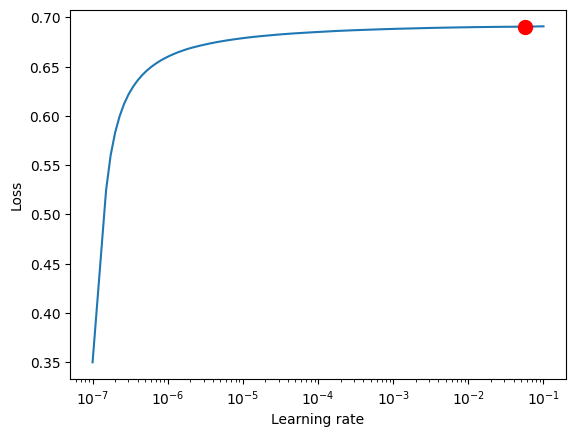

In [ ]:
fig = results.plot(suggest=True)

In [ ]:
# next(iter(trainer.model.optimizer.param_groups))

In [ ]:
trainer.fit(model=lightning_model, datamodule=data_manager)

bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 1.8 M 
1 | loss_func | BCEWithLogitsLoss  | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.281     Total estimated model params size (MB)


RuntimeError: Missing folder: logs/HeteroGat1\version_17.

In [ ]:
trainer.checkpoint_callback.best_model_path

'logs/HeteroGat1\\version_17\\checkpoints\\epoch=10-step=2827.ckpt'

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from os import path
def plot_csv_logger(csv_path, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
    metrics = pd.read_csv(csv_path)

    aggregation_metrics = []
    agg_col = 'epoch'
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggregation_metrics.append(agg)

    df_metrics = pd.DataFrame(aggregation_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
    plt.show()

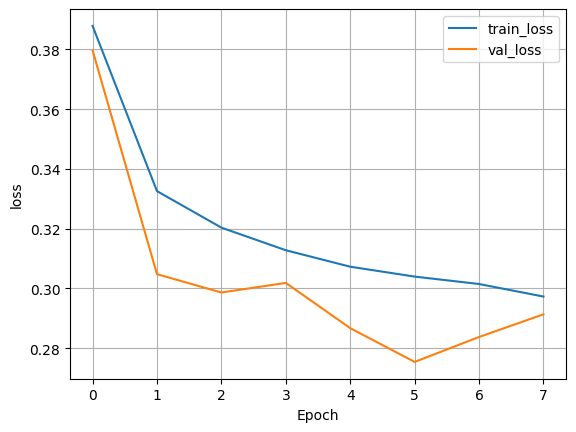

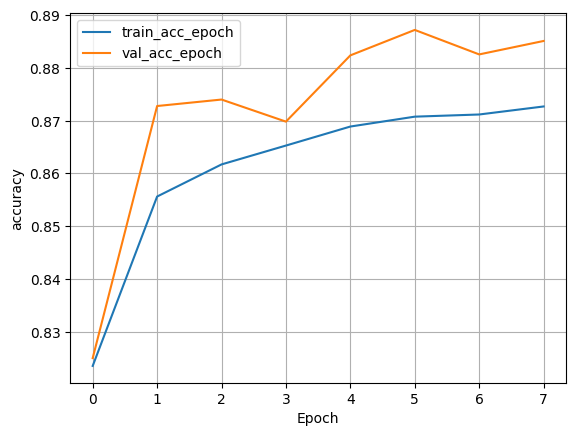

In [ ]:
plot_csv_logger(r'C:\Users\fardin\Projects\ColorIntelligence\logs\hetero_model_5\version_0\metrics.csv', loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])